<a href="https://colab.research.google.com/github/AbdulxoliqMirzayev/Valyuta_prognozi/blob/main/usd_uzs_prognoz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!pip install ta         # KERAKLI KUTUBHONALARNI YUKLAB OLAMIZ.
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install tensorflow
!pip install scikit-learn
!pip install pandas numpy matplotlib scikit-learn tensorflow ta-lib plotly


In [124]:
# Kerakli kutubxonalarni import qilamiz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')


In [125]:
# Datasetni yuklab olamiz
df = pd.read_csv('USD_UZS Historical Data.csv')

# Date ustunini datetime formatiga o'tkazish
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Faqat Date va Price ustunlarini saqlash
df = df[['Date', 'Price']]

# Vaqt bo'yicha tartiblash (eng eski birinchi)
df = df.sort_values(by='Date').reset_index(drop=True)

# Price ustunidagi vergullarni olib tashlash va float ga o'tkazamiz judaham muhum
df['Price'] = df['Price'].str.replace(',', '').astype(float)

# NaN qiymatlarni olib tashlaymiz agar nan qiymatlar qolib ketsa model notugri bashorat qilishni boshlaydi
df = df.dropna(subset=['Price'])


Bu qism ma’lumotlar orasidagi bo‘sh kunlarni to‘ldirib,  model uchun zarur bo‘lgan uzluksiz kunlik ketma-ketlikni yaratadi. Chastotani daily qilib belgilash modelning vaqt bo‘yicha bashorat qilish aniqligini keskin oshiradi

In [126]:

# Kunlik chastotani ta'minlash uchun reindex qilish va bo'sh kunlarni oldingi qiymat bilan to'ldirishimiz kerak bo'lmasa model notugri ishlaydi
start_date = df['Date'].min()
end_date = df['Date'].max()
all_dates = pd.date_range(start_date, end_date, freq='D')
df = df.set_index('Date').reindex(all_dates)
df['Price'] = df['Price'].ffill()

# Index chastotasini 'D' (daily) qilish - bu forecast uchun muhim
df.index.freq = 'D'


In [131]:

# Datasetni ko'rib olamiz
print("Dataset shakli:", df.shape)
print("Birinchi 5 qator:\n")

df.head()

Dataset shakli: (6051, 1)
Birinchi 5 qator:



,Price
2009-05-12,712.35
2009-05-13,712.35
2009-05-14,712.35
2009-05-15,712.35
2009-05-16,712.35


In [132]:
print("Oxirgi 5 qator:\n" )
df.tail()

Oxirgi 5 qator:



,Price
2025-11-30,11945.00
2025-12-01,11895.57
2025-12-02,11880.93
2025-12-03,11912.38
2025-12-04,11884.19


ADF testi narx qatorining stasionarligini aniqlaydi. Bu bashorat modeli o‘rganishi kerak bo‘lgan ma’lumotning statistik barqarorligini tekshirish uchun ishlatiladi

In [133]:
#  Stasionarlikni tekshirish (ADF test)
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -0.5801667783685994
p-value: 0.8754008420848861


Differensiyalash  narxlarning kunlik o‘zgarishini hisoblab, ma’lumotni trenddan tozalaydi. Bu stasionarlikni oshirib, modelning bashorat aniqligini yaxshilaydi.

In [134]:
# Differensiyalash (d=1)
df['Price_diff'] = df['Price'].diff().dropna()
result_diff = adfuller(df['Price_diff'].dropna())
print('Differensiyalangan ADF Statistic:', result_diff[0])
print('Differensiyalangan p-value:', result_diff[1])


Differensiyalangan ADF Statistic: -23.5160084081955
Differensiyalangan p-value: 0.0


ACF va PACF grafiklari ARIMA modelining p va q parametrlari qanday bo‘lishi kerakligini ko‘rsatadi. Bu modelni optimal sozlash va bashorat aniqligini oshirish uchun ishlatiladi.

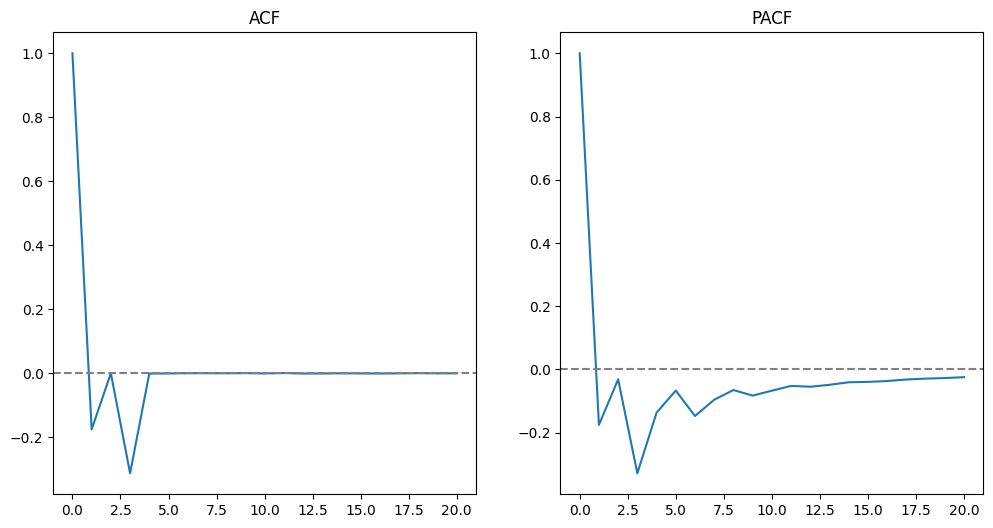

In [135]:

# ARIMA parametrlarini taxmin qilish (ACF va PACF)
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(df['Price_diff'].dropna(), nlags=20)
lag_pacf = pacf(df['Price_diff'].dropna(), nlags=20)

# ACF va PACF grafiklarini chiqaramiz
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.title('ACF')
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.title('PACF')
plt.show()


In [136]:
# Train/Test bo'lish va model o'qitish
# Oxirgi 30 kunni test uchun ajratish long forecast muammosini oldini olish uchun
train_size = len(df) - 30
train = df['Price'][:train_size]
test = df['Price'][train_size:]


ARIMA  vaqt qatorlari (time-series) uchun eng mashhur statistik model.
Valyuta, aksiyalar va makroiqtisodiy ko‘rsatkichlarni o‘rta muddatli bashorat qilish uchun juda mos. Tanlangan (1,1,1) parametrlari vaqt qatori trendini to‘g‘rilaydi va narxning kechagi qiymatlariga asoslangan bashoratni shakllantiradi.

In [138]:
# ARIMA modelini yaratish va o'qitish
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Model haqida ma'lumotni korib olamiz
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 6021
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -43783.586
Date:                Thu, 04 Dec 2025   AIC                          87573.172
Time:                        08:50:16   BIC                          87593.281
Sample:                    05-12-2009   HQIC                         87580.154
                         - 11-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5849      0.003    218.719      0.000       0.580       0.590
ma.L1         -0.9314      0.002   -495.239      0.000      -0.935      -0.928
sigma2      1.215e+05    121.379   1001.355      0.0

Bu kod modelning test qismi bo‘yicha qanchalik aniq bashorat qilganini tekshiradi. MSE va MAE orqali modelning xato darajasi o‘lchanadi

In [151]:
# Test uchun bashorat va aniqlikni hisoblash uchuun

forecast_test = model_fit.forecast(steps=len(test))
forecast_test = pd.Series(forecast_test, index=test.index)

# Aniqlik metrikalari
mse = mean_squared_error(test, forecast_test)
mae = mean_absolute_error(test, forecast_test)



In [140]:

# Kelajak bashorati (2025-12-05 dan 2025-12-12 gacha)
full_model = ARIMA(df['Price'], order=(1, 1, 1))
full_model_fit = full_model.fit()

last_date = df.index[-1]
future_dates = pd.date_range(last_date + timedelta(days=1), periods=8, freq='D')
forecast_future = full_model_fit.forecast(steps=8)
forecast_future = pd.Series(forecast_future, index=future_dates)


**Bu grafik Narxning tushishi yoki ko'tarilishi emas bu indekator grafigi**

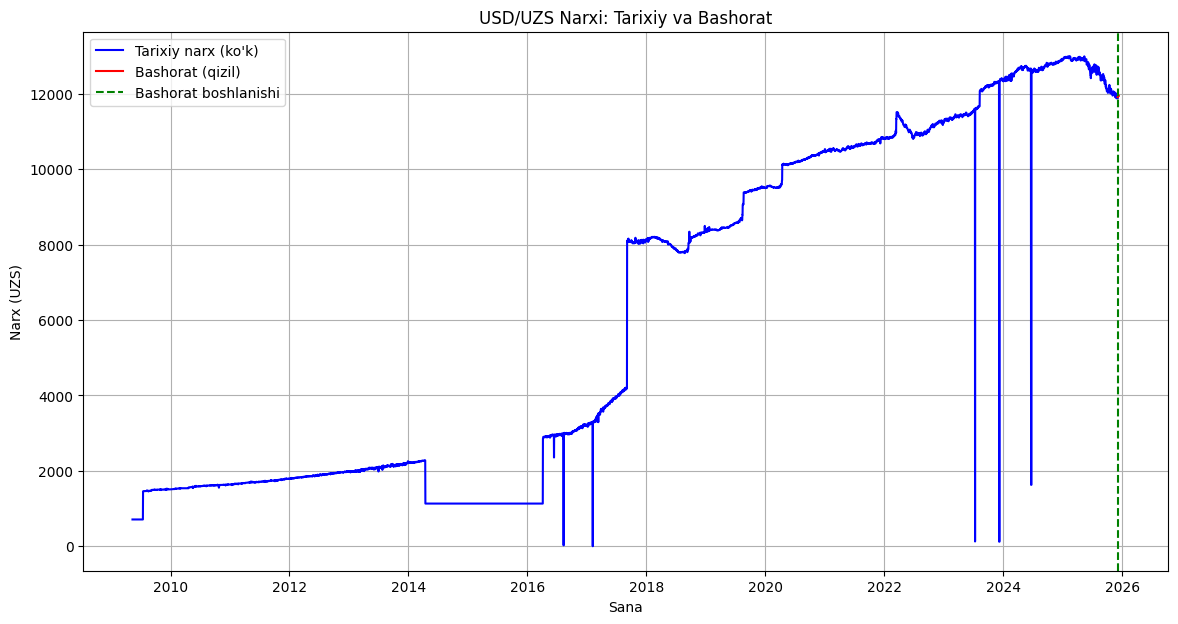

In [145]:
#Grafikda chiqaramiz . bu indekatorlar yordamida trendni o'zgarishi
plt.figure(figsize=(14, 7))
plt.plot(df['Price'], label='Tarixiy narx (ko\'k)', color='blue')
plt.plot(forecast_future, label='Bashorat (qizil)', color='red')
plt.axvline(x=last_date, color='green', linestyle='--', label='Bashorat boshlanishi')
plt.title('USD/UZS Narxi: Tarixiy va Bashorat')
plt.xlabel('Sana')
plt.ylabel('Narx (UZS)')
plt.legend()
plt.grid(True)
plt.show()


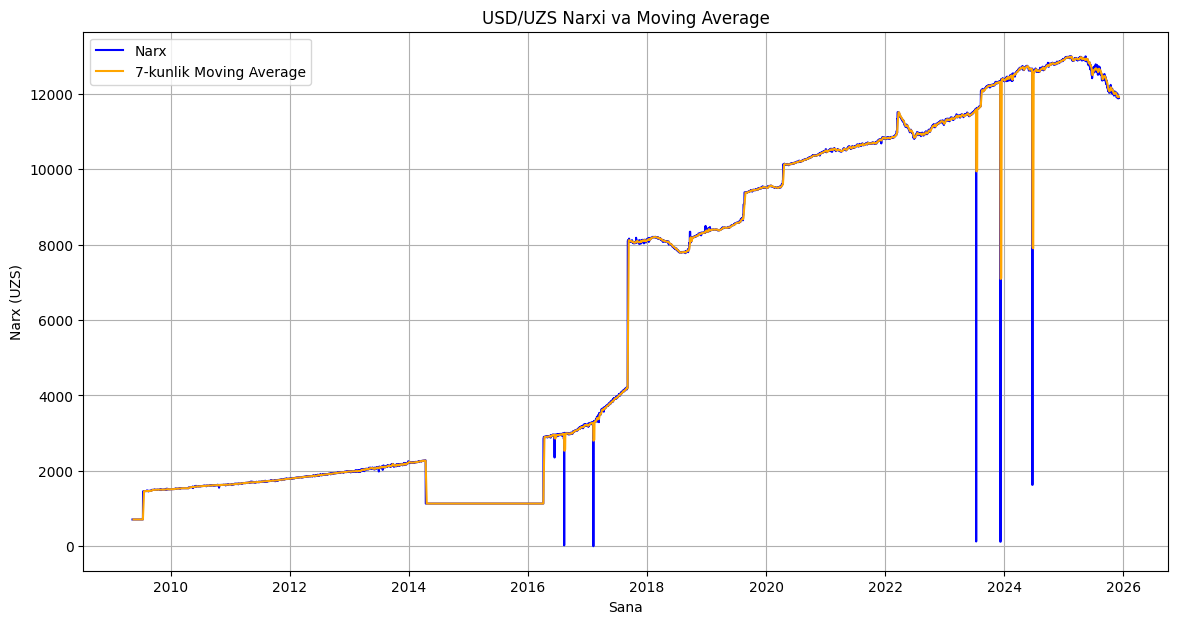

In [146]:

# Qo'shimcha indikator  moving average
df['MA7'] = df['Price'].rolling(window=7).mean()

# Moving Average grafik
plt.figure(figsize=(14, 7))
plt.plot(df['Price'], label='Narx', color='blue')
plt.plot(df['MA7'], label='7-kunlik Moving Average', color='orange')
plt.title('USD/UZS Narxi va Moving Average')
plt.xlabel('Sana')
plt.ylabel('Narx (UZS)')
plt.legend()
plt.grid(True)
plt.show()



In [150]:
print(f"Model aniqligi (MSE): {mse}")
print(f"Model aniqligi (MAE): {mae} %")

Model aniqligi (MSE): 12581.922440263395
Model aniqligi (MAE): 94.10883801968933 %


In [153]:
print("Bashorat qilingan narxlar (2025-12-05 dan 2025-12-12 gacha):\n")
print(forecast_future.round(2))

Bashorat qilingan narxlar (2025-12-05 dan 2025-12-12 gacha):

2025-12-05    11910.11
2025-12-06    11925.27
2025-12-07    11934.14
2025-12-08    11939.33
2025-12-09    11942.36
2025-12-10    11944.14
2025-12-11    11945.17
2025-12-12    11945.78
Freq: D, Name: predicted_mean, dtype: float64


In [ ]:
# Model 94 foiz aniqlikda bizga natija berdi bu faqat matematik hisoblash buni aniqligini oshirish uchun
# sentement analysis qo'shish kerak geosiyosiy fundamental omillarni ham qo'shish kerak. va eng muhimi real time malumotlar kerak bo'ladi bizga.
